# Learning to Resize Images for Vision Transformer


In this notebook, it's shown how we can train a higher resolution image for **Vision Transformer** model. Usually transformer based models with high resolution may not fit into GPU. In such cases, we can adopt a **Trainable Resizer** mechanism as a backbone of the transformer models and perform as a joint learning of the image resizer and recognition models simultaneously.

[**Learning to Resize Images for Computer Vision Tasks** - Google Research](https://arxiv.org/pdf/2103.09950v1.pdf). For a given image resolution and a model, this research work answer how to best resize that image in a target resolution. Off-the-shelf image resizers for example: bilinear, bicubic methods are commonly used in most of the machine learning softwares. But this may limit the on-task performance of the trained model. In the above work, it's shown that typical linear resizer can be replaced with the **Learned Resizer**. 

In the paper, they showed that the proposed resizer mechanism improve the classificaiton mdoels. They added the resizer mechanism to the classification models such as `DenseNet`, `InceptionNet` etc. In this way, we can input very large image size and the resizer mechanism will downscale the image appropriately for the actual mdoel. 

![rtee](https://user-images.githubusercontent.com/17668390/138254072-f87daa13-12cc-4c6a-9145-a567f644cb12.png)

[**Vision Transformer** - Google Research](https://arxiv.org/pdf/2010.11929.pdf). We know that the transformer models are computationally expensive. And thus limits the input size roughly around `224`, `384`. So, the idea is to use this **resizer mechanism** as a bacbone of the **vision transformer**, so that we can input enough large image for **joint learning**. So, the overall model architecture could be 

![Presentation2](https://user-images.githubusercontent.com/17668390/138256285-c24f98db-ce35-4877-8741-221fd57d895e.jpg)

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import callbacks
from tensorflow.keras import layers, losses, optimizers, metrics
import tensorflow_hub as hub

try:
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass 

# enable mixed_precision and jit compiler 
tf.keras.mixed_precision.set_global_policy('mixed_float16')
tf.config.optimizer.set_jit(True)

In [2]:
INP_SIZE      = (512, 512) # Input size of the Image Resizer Module (IRM)
TARGET_SIZE   = (224, 224) # Output size of IRM and Input size of the Vision Transformer 
INTERPOLATION = "bilinear"

# Prepare tf.data object

In [3]:
NUM_FOLDS  = 10
BATCH_SIZE = 24
SEED       = INP_SIZE[0]

DATA_DIR  = '../input/petfinder-pawpularity-score/'
TRAIN_DIR = DATA_DIR + 'train/'
TEST_DIR  = DATA_DIR + 'test/'

# SetAutoTune
AUTOTUNE = tf.data.AUTOTUNE  

def build_augmenter(is_labelled):
    def augment(img):
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_saturation(img, 0.65, 1.05)
        img = tf.image.random_brightness(img, 0.05)
        img = tf.image.random_contrast(img, 0.75, 1.05)
        img = tf.image.random_hue(img, 0.05)
        return img
    
    def augment_with_labels(img, label):
        return augment(img), label
    return augment_with_labels if is_labelled else augment

def build_decoder(is_labelled):
    def decode(path):
        file_bytes = tf.io.read_file(path)
        img = tf.image.decode_jpeg(file_bytes, channels = 3)
        img = tf.image.resize(img, (INP_SIZE))
        return tf.divide(img, 255.)
    
    def decode_with_labels(path, label):
        return decode(path), label
    
    return decode_with_labels if is_labelled else decode

def create_dataset(df, 
                   batch_size  = 32, 
                   is_labelled = False, 
                   augment     = False, 
                   repeat      = False, 
                   shuffle     = False):
    decode_fn    = build_decoder(is_labelled)
    augmenter_fn = build_augmenter(is_labelled)
    
    # Create Dataset
    if is_labelled:
        dataset = tf.data.Dataset.from_tensor_slices((df['Id'].values, df['target_value'].values))
    else:
        dataset = tf.data.Dataset.from_tensor_slices((df['Id'].values))
        
    dataset = dataset.map(decode_fn, num_parallel_calls = AUTOTUNE)
    dataset = dataset.map(augmenter_fn, num_parallel_calls = AUTOTUNE) if augment else dataset
    dataset = dataset.repeat() if repeat else dataset
    dataset = dataset.shuffle(1024, reshuffle_each_iteration = True) if shuffle else dataset
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [4]:
# Load Train Data
train_df = pd.read_csv(f'{DATA_DIR}train.csv')
train_df['Id'] = train_df['Id'].apply(lambda x: f'{TRAIN_DIR}{x}.jpg')

# Set a specific label to be able to perform stratification
train_df['stratify_label'] = pd.qcut(train_df['Pawpularity'], q = 30, labels = range(30))

# Though it's a regression problem, but it's been informed that if we treat it as a -
# classification problmen, it would be useful. So, here we normalize the target labels.
# Label value to be used for feature model 'classification' training.
train_df['target_value'] = train_df['Pawpularity'] / 100.

# Summary
print(f'train_df: {train_df.shape}')
train_df.head()

train_df: (9912, 16)


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,stratify_label,target_value
0,../input/petfinder-pawpularity-score/train/000...,0,1,1,1,0,0,1,0,0,0,0,0,63,26,0.63
1,../input/petfinder-pawpularity-score/train/000...,0,1,1,0,0,0,0,0,0,0,0,0,42,20,0.42
2,../input/petfinder-pawpularity-score/train/001...,0,1,1,1,0,0,0,0,1,1,0,0,28,9,0.28
3,../input/petfinder-pawpularity-score/train/001...,0,1,1,1,0,0,0,0,0,0,0,0,15,2,0.15
4,../input/petfinder-pawpularity-score/train/001...,0,0,0,1,0,0,1,0,0,0,0,0,72,27,0.72


In [5]:
# Load Test Data
test_df = pd.read_csv(f'{DATA_DIR}test.csv')
test_df['Id'] = test_df['Id'].apply(lambda x: f'{TEST_DIR}{x}.jpg')
test_df['Pawpularity'] = 0

# Summary
print(f'test_df: {test_df.shape}')
test_df.head()

test_df: (8, 14)


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,../input/petfinder-pawpularity-score/test/4128...,1,0,1,0,0,1,1,0,0,1,0,1,0
1,../input/petfinder-pawpularity-score/test/43a2...,0,1,0,0,0,0,1,1,0,0,0,0,0
2,../input/petfinder-pawpularity-score/test/4e42...,0,0,0,1,0,1,1,1,0,1,1,1,0
3,../input/petfinder-pawpularity-score/test/80bc...,1,0,1,0,0,0,0,0,0,0,1,0,0
4,../input/petfinder-pawpularity-score/test/8f49...,1,1,1,0,1,1,0,1,0,1,1,0,0


# Implementation of Learning to Resize Mechanism

Quoting from the paper: 

> Our proposed resizer architecture is shown in below figure. Perhaps the most important characteristics of this model are
(1) the bilinear feature resizing, and (2) the skip connection that accommodates combining the bilinearly resized image
and the CNN features. The former factor allows for incorporation of features computed at original resolution into
the model. Also, the skip connection accommodates for an easier learning process, because the resizer model can directly pass the bilinearly resized image into the baseline task. Note that the bilinear feature resizer shown in Figure 3 acts as a feed-forward bottleneck (down-scaling), but in principle it can also act as an inverse bottleneck as well (up-scaling). It is worth noting that unlike typical encoderdecoder architectures, the proposed architecture allows for resizing an image to any target size and aspect ratio. It is also important to highlight that performance of the learned resizer is barely dependent on the bilinear resizer choice, meaning it can be safely replaced with o

![image resizer](https://user-images.githubusercontent.com/17668390/138250657-29995830-b903-447f-8729-09b72b90ab3c.png)

In [6]:
# ref: https://keras.io/examples/vision/learnable_resizer/
def residual_block(x):
    shortcut = x
    def conv_bn_leaky(inputs, filters, kernel_size, strides):
        x = layers.Conv2D(filters, 
                          kernel_size, 
                          strides=strides, 
                          use_bias=False, 
                          padding='same')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)
        return x 
    
    def conv_bn(inputs, filters, kernel_size, strides):
        x = layers.Conv2D(filters, 
                          kernel_size, 
                          strides, 
                          padding='same')(inputs)
        x = layers.BatchNormalization()(x)
        return x 
    
    x = conv_bn_leaky(x, 16, 3, 1)
    x = conv_bn(x, 16, 3, 1)
    x = layers.add([shortcut, x])
    return x


def get_learnable_resizer(filters=16,
                          num_res_blocks=1, 
                          interpolation=INTERPOLATION):
    
    inputs = layers.Input(shape=[None, None, 3])
    
    # First, perform naive resizing.
    naive_resize = layers.Resizing(
        *TARGET_SIZE, interpolation=interpolation
    )(inputs)

    # First convolution block without batch normalization.
    x = layers.Conv2D(filters=filters, kernel_size=7, strides=1, padding='same')(inputs)
    x = layers.LeakyReLU(0.2)(x)

    # Second convolution block with batch normalization.
    x = layers.Conv2D(filters=filters, kernel_size=1, strides=1, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.BatchNormalization()(x)

    # Intermediate resizing as a bottleneck.
    bottleneck = layers.Resizing(
        *TARGET_SIZE, interpolation=interpolation
    )(x)
    
    # Residual passes.
    x = residual_block(bottleneck)
    for i in range(1, num_res_blocks):
        x = residual_block(x)
        
    # Projection.
    x = layers.Conv2D(
        filters=filters, kernel_size=3, strides=1, padding="same", use_bias=False
    )(x)
    x = layers.BatchNormalization()(x)

    # Skip connection.
    x = layers.Add()([bottleneck, x])

    # Final resized image.
    x = layers.Conv2D(filters=3, kernel_size=7, strides=1, padding="same")(x)
    final_resize = layers.Add()([naive_resize, x])
    return keras.Model(inputs, final_resize, name="learnable_resizer")

In [7]:
# The number of residual block in image resizer modules 
NUM_RESIDUAL_BLOCK = 10
LEARNABLE_RESIZER  = get_learnable_resizer(num_res_blocks=NUM_RESIDUAL_BLOCK)

**Check**

Let's check how raw image get tansformed with this resizer blocks with initial states.

In [8]:
training_dataset = create_dataset(train_df,
                                  batch_size  = BATCH_SIZE, 
                                  is_labelled = True, 
                                  augment = True,
                                  repeat  = False, 
                                  shuffle = False)
sample_images, _ = next(iter(training_dataset))

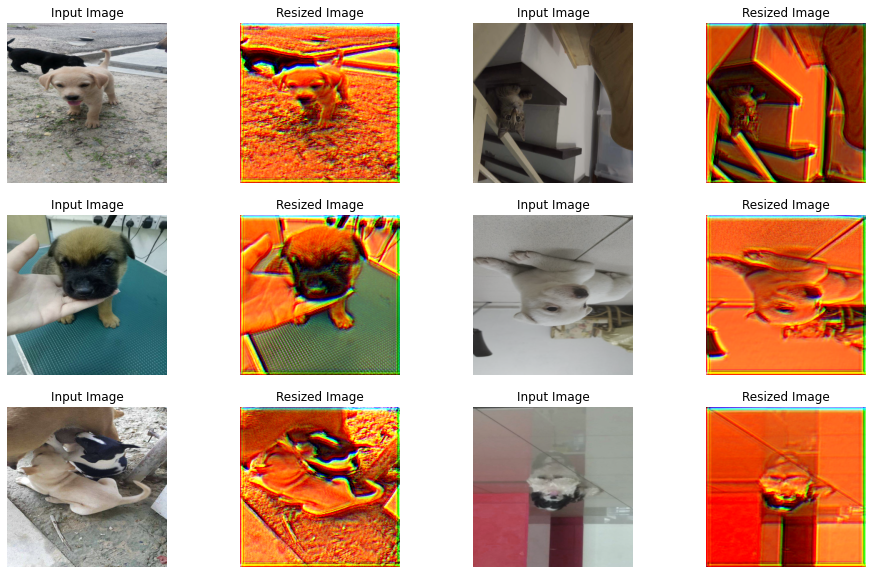

In [9]:
plt.figure(figsize=(16, 10))
for i, image in enumerate(sample_images[:6]):
    ax = plt.subplot(3, 4, 2 * i + 1)
    plt.title("Input Image")
    plt.imshow(image.numpy().squeeze())
    plt.axis("off")

    ax = plt.subplot(3, 4, 2 * i + 2)
    resized_image = LEARNABLE_RESIZER(image[None, ...])
    resized_image = tf.cast(resized_image, dtype=tf.float32)
    plt.title("Resized Image")
    plt.imshow(resized_image.numpy().squeeze())
    plt.axis("off")

# Learned Resizer + Vision Transformer 

We'll use vision transformer from [tf.hub](https://tfhub.dev/sayakpaul/collections/vision_transformer/1). However, initially we enabled mixed precision technique. But in `hub.KerasLayer`, the data types used by a saved model have been fixed at saving time, [source-link](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer). So, we may need to set global policy back to `float32` right before loading the `hub.KerasLayer` and reset to `float16` after that for mixed precision training. Directly quoting form the source:

> Note: The data types used by a saved model have been fixed at saving time. Using tf.keras.mixed_precision etc. has no effect on the saved model that gets loaded by a hub.KerasLayer.

In [10]:
EPOCHS       = 20
VERBOSE      = 1
lr           = 0.0003
LABEL_SMOOTH = 0.01

In [11]:
handle = "../input/vitjax2tf"
def get_model(plot_modal, 
              print_summary, 
              with_compile):
    # Input layer + Resizer Blocks
    inputs = layers.Input((INP_SIZE[0], INP_SIZE[1], 3))
    x = LEARNABLE_RESIZER(inputs)
    
    # Loading Vision Transformer from tf.hub
    keras.mixed_precision.set_global_policy('float32')
    hub_layer = hub.KerasLayer(handle, trainable=True)
    backbone = keras.Sequential(
        [
            layers.InputLayer((TARGET_SIZE[0], TARGET_SIZE[1], 3)),
            hub_layer
        ], name='vit'
    )
    keras.mixed_precision.set_global_policy('mixed_float16')
    outputs = backbone(x)
    
    # End layers with classifier. 
    tail = keras.Sequential(
            [
                layers.Dropout(0.5),
                layers.BatchNormalization(),
                layers.Dense(1, activation = 'sigmoid', dtype='float32')
            ], name='head'
        )
    
    # bind all: complete model 
    model = keras.Model(inputs, tail(outputs))
    
    if plot_modal:
        display(keras.utils.plot_model(model, 
                                       show_shapes=True, 
                                       show_layer_names=True, 
                                       expand_nested=True))
    if print_summary:
        print(model.summary())
        
    if with_compile:
        model.compile(
            optimizer = keras.optimizers.Adam(learning_rate = lr),  
            loss = losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTH), 
            metrics = [metrics.RootMeanSquaredError('rmse')]
        )
    return model 

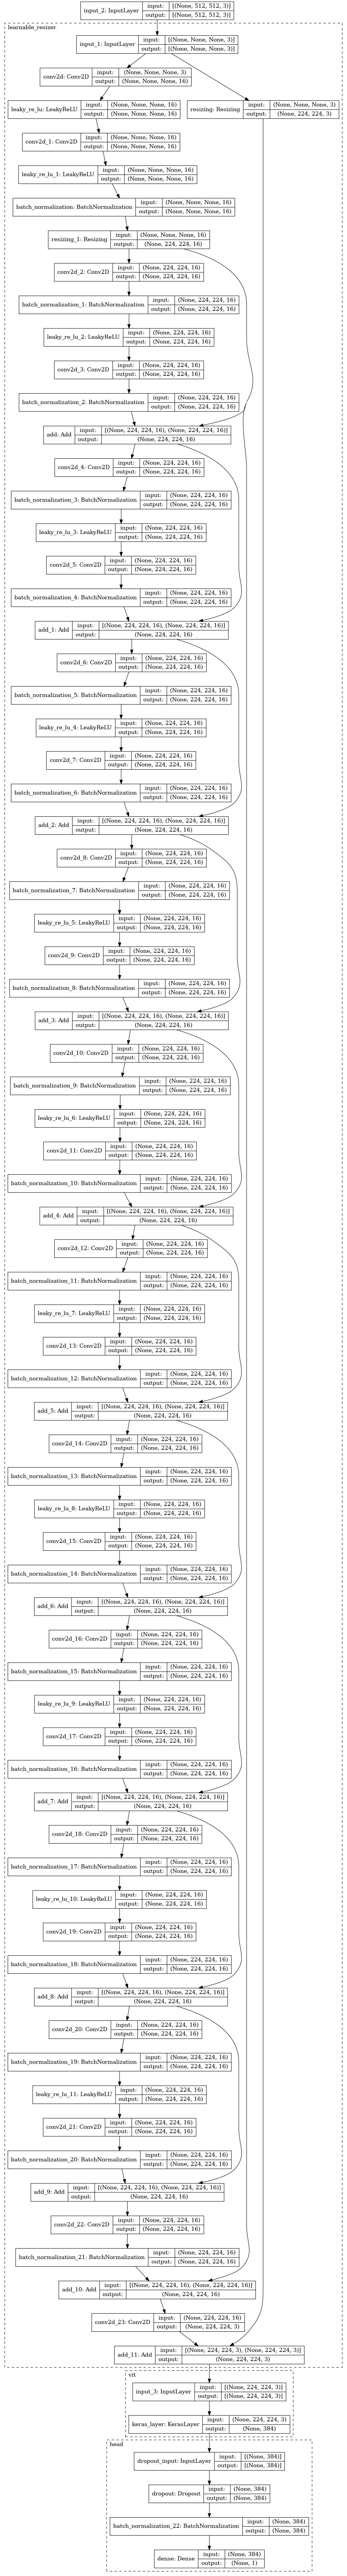

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
learnable_resizer (Functiona (None, 224, 224, 3)       54947     
_________________________________________________________________
vit (Sequential)             (None, 384)               21665664  
_________________________________________________________________
head (Sequential)            (None, 1)                 1921      
Total params: 21,722,532
Trainable params: 21,721,060
Non-trainable params: 1,472
_________________________________________________________________
None


In [12]:
get_model(plot_modal=True, print_summary=True, with_compile=False)

In [13]:
def get_lr_callback(batch_size=8):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * batch_size 
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        return lr
    return callbacks.LearningRateScheduler(lrfn, verbose=True)

def model_callback(fold):
    ckpt = callbacks.ModelCheckpoint(f'feature_model_{fold}.h5',
                                     verbose = 1, 
                                     monitor = 'val_rmse',
                                     mode = 'min',
                                     save_weights_only = True,
                                     save_best_only = True)
    
    return [ckpt, get_lr_callback(BATCH_SIZE)]

In [14]:
import gc
from sklearn.model_selection import StratifiedKFold

# OOF RMSE Placeholder
all_val_loss = []
kfold = StratifiedKFold(n_splits = NUM_FOLDS, 
                        shuffle = True, random_state = SEED)
for fold, (train_index, val_index) in enumerate(kfold.split(train_df.index,
                                                            train_df['stratify_label'])):
    if fold == 1:
        print(f'\nFold {fold}\n')
        # Pre model.fit cleanup
        tf.keras.backend.clear_session()
        gc.collect()

        # Create Model
        model = get_model(plot_modal    = False, 
                          print_summary = False,
                          with_compile  = True)
        for i in range(len(model.weights)):
            model.weights[i]._handle_name = model.weights[i].name + str(i)
    
        # Create TF Datasets
        trn = train_df.iloc[train_index]
        val = train_df.iloc[val_index]
        training_dataset = create_dataset(trn, 
                                          batch_size  = BATCH_SIZE, 
                                          is_labelled = True, 
                                          augment     = True, 
                                          repeat      = True, 
                                          shuffle     = True)
        validation_dataset = create_dataset(val, 
                                            batch_size  = BATCH_SIZE, 
                                            is_labelled = True,
                                            augment     = False, 
                                            repeat      = True,
                                            shuffle     = False)
        # Fit Model
        history = model.fit(training_dataset,
                            epochs = EPOCHS,
                            steps_per_epoch  = trn.shape[0] // BATCH_SIZE,
                            validation_steps = val.shape[0] // BATCH_SIZE,
                            callbacks = model_callback(fold),
                            validation_data = validation_dataset,
                            verbose = VERBOSE)   

        # Validation Information
        best_val_loss = min(history.history['val_rmse'])
        all_val_loss.append(best_val_loss)
        print(f'\nValidation RMSE: {best_val_loss}\n')


Fold 1

Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 5e-06.
371/371 [==============================] - 285s 561ms/step - loss: 0.8638 - rmse: 0.3384 - val_loss: 0.7186 - val_rmse: 0.2579

Epoch 00001: val_rmse improved from inf to 0.25786, saving model to feature_model_1.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
371/371 [==============================] - 202s 543ms/step - loss: 0.8442 - rmse: 0.3294 - val_loss: 0.7485 - val_rmse: 0.2863

Epoch 00002: val_rmse did not improve from 0.25786
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 1.5000000000000002e-05.
371/371 [==============================] - 202s 545ms/step - loss: 0.8321 - rmse: 0.3215 - val_loss: 0.6810 - val_rmse: 0.2220

Epoch 00003: val_rmse improved from 0.25786 to 0.22201, saving model to feature_model_1.h5
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 2.0000000000000005e-05.
371/371 [==

**Check**

Sample output of Trained Resizer.

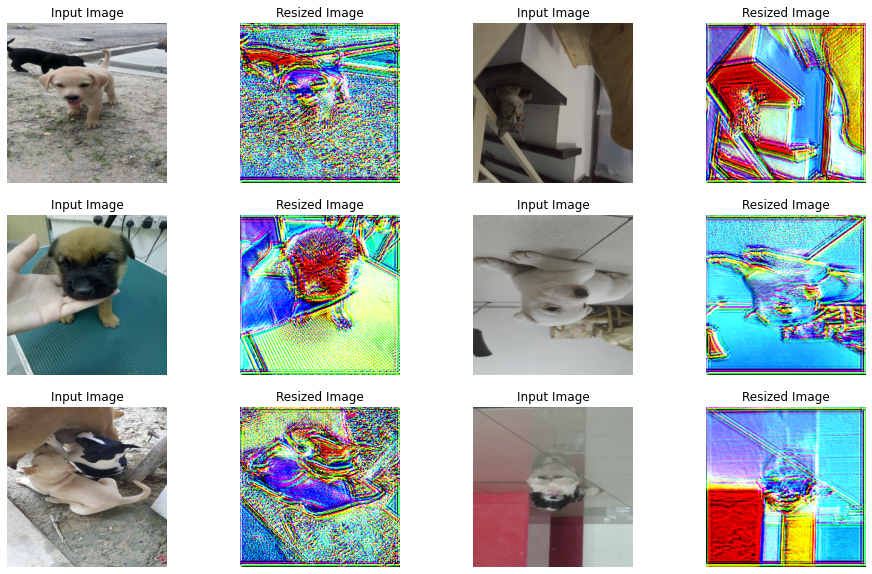

In [15]:
plt.figure(figsize=(16, 10))
for i, image in enumerate(sample_images[:6]):
    ax = plt.subplot(3, 4, 2 * i + 1)
    plt.title("Input Image")
    plt.imshow(image.numpy().squeeze())
    plt.axis("off")

    ax = plt.subplot(3, 4, 2 * i + 2)
    resized_image = LEARNABLE_RESIZER(image[None, ...])
    resized_image = tf.cast(resized_image, dtype=tf.float32)
    plt.title("Resized Image")
    plt.imshow(resized_image.numpy().squeeze())
    plt.axis("off")

**Inference**

In [16]:
cb_test_set = create_dataset(test_df, 
                             batch_size  = BATCH_SIZE,
                             is_labelled = False,
                             repeat      = False, 
                             shuffle     = False)

submission_df = pd.read_csv(f'{DATA_DIR}sample_submission.csv')
# we train only first fold.
model.load_weights("./feature_model_1.h5")
submission_df['Pawpularity'] = model.predict(cb_test_set)*100
submission_df.to_csv('submission.csv', index = False)
submission_df.head(10)

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,38.816116
1,43a2262d7738e3d420d453815151079e,37.196384
2,4e429cead1848a298432a0acad014c9d,39.052822
3,80bc3ccafcc51b66303c2c263aa38486,35.507862
4,8f49844c382931444e68dffbe20228f4,37.310390
5,b03f7041962238a7c9d6537e22f9b017,35.921455
6,c978013571258ed6d4637f6e8cc9d6a3,36.341442
7,e0de453c1bffc20c22b072b34b54e50f,36.161129
